In [ ]:
import os, sys
os.environ['CUDA_VISIBLE_DEVICES'] = '2,3'
from pathlib import Path
from tqdm import tqdm
import numpy as np
from einops import einsum
import cv2
from PIL import Image
import lovely_tensors as lt
lt.monkey_patch()
import imageio.v3 as iio
import torch

from hmr4d.dataset.bedlam.bedlam import BedlamDatasetV2 #52,788 samples
from hmr4d.utils.body_model import BodyModelSMPLH, BodyModelSMPLX
from hmr4d.utils.body_model.smplx_lite import SmplxLiteSmplN24
from hmr4d.utils.geo.hmr_global import get_c_rootparam, get_R_c2gv, get_tgtcoord_rootparam, get_T_w2c_from_wcparams
from hmr4d.utils.geo.hmr_cam import create_camera_sensor
from hmr4d.utils.geo_transform import compute_cam_angvel, apply_T_on_points, compute_T_ayfz2ay, move_to_start_point_face_z
from hmr4d.utils.net_utils import get_valid_mask
from hmr4d.utils.wis3d_utils import convert_motion_as_line_mesh
from hmr4d.utils.video_io_utils import read_video_np, save_video, get_writer
from hmr4d.utils.vis.renderer import Renderer, get_global_cameras_static, get_ground_params_from_points
from hmr4d.utils.vis.renderer_utils import simple_render_mesh

# [12/23 15:45:21][INFO] [AMASS] 18086 sequences. Elapsed: 2.35s
# [12/23 15:45:21][INFO] [AMASS] has 64.7 hours motion -> Resampled to 52788 samples.
# [12/23 15:40:11][INFO] [BEDLAM] 37537 sequences. 
# [12/23 15:40:24][INFO] [H36M] 600 sequences. Elapsed: 0.61s
# [12/23 15:40:25][INFO] [H36M] has 8.7 hours motion -> Resampled to 6196 samples. 
# [12/23 15:46:37][INFO] [3DPW] has 7.5 minutes motion -> Resampled to 88 samples. 

device = 'cuda:0'

In [2]:
smpl = BodyModelSMPLH(
    model_path="inputs/checkpoints/body_models", model_type="smpl",
    gender="neutral", num_betas=10, create_body_pose=False, 
    create_betas=False, create_global_orient=False, create_transl=False,
).to(device)
smplx = BodyModelSMPLX(
    model_path="inputs/checkpoints/body_models", model_type="smplx",
    gender="neutral", num_pca_comps=12, flat_hand_mean=False,
).to(device)
smplx2smpl = torch.load("hmr4d/utils/body_model/smplx2smpl_sparse.pt").to(device)
faces_smpl = torch.from_numpy((smpl.faces).astype("int")).unsqueeze(0).to(device)
faces_smplx = torch.from_numpy((smplx.faces).astype("int")).unsqueeze(0).to(device)
J_regressor = torch.load("hmr4d/utils/body_model/smpl_neutral_J_regressor.pt").to(device)

smplx_lite = SmplxLiteSmplN24()

In [3]:
### BEDLAM Train Dataset --Load Dataset-- ###

root = Path("inputs/BEDLAM/hmr4d_support")
min_motion_frames = 60
max_motion_frames = 120
lazy_load=True
random1024=False

mid_to_valid_range = {}
mid_to_imgfeat_dir = {}

mid_to_valid_range_ = torch.load(root / "mid_to_valid_range_all60.pt")
mid_to_valid_range.update(mid_to_valid_range_)
mid_to_imgfeat_dir.update({mid: root / "imgfeats/bedlam_all60" for mid in mid_to_valid_range_})

mid_to_valid_range_ = torch.load(root / "mid_to_valid_range_maxspan60.pt")
mid_to_valid_range.update(mid_to_valid_range_)
mid_to_imgfeat_dir.update({mid: root / "imgfeats/bedlam_maxspan60" for mid in mid_to_valid_range_})

motion_files = torch.load(root / "smplpose_v2.pth")
idx2meta = list(mid_to_valid_range.keys())

print(f"Total motion files: {len(idx2meta):,}")

Total motion files: 37,537


In [6]:
idx = 30
np.random.seed(42)

mid = idx2meta[idx]
data = motion_files[mid].copy()

# Random select a subset
range1, range2 = mid_to_valid_range[mid]  # [range1, range2)
mlength = range2 - range1
if mlength < min_motion_frames:  # the minimal mlength is 30 when generating data
    start = range1
    length = mlength
else:
    effect_max_motion_len = min(max_motion_frames, mlength)
    length = np.random.randint(min_motion_frames, effect_max_motion_len + 1)  # [low, high)
    start = np.random.randint(range1, range2 - length + 1)
end = start + length
data["start_end"] = (start, end)
data["length"] = length
for k, v in data.items():
    if isinstance(v, torch.Tensor) and len(v.shape) > 1 and k != "skeleton":
        data[k] = v[start:end]
        
# Load img(as feature) : {mid -> 'features', 'bbx_xys', 'img_wh', 'start_end'}
imgfeat_dir = mid_to_imgfeat_dir[mid]
f_img_dict = torch.load(imgfeat_dir / f"{Path(mid).parts[-3]}/{Path(mid).parts[-1]}.pt")
start_mapped = start - f_img_dict["start_end"][0]
end_mapped = end - f_img_dict["start_end"][0]
data["f_imgseq"] = f_img_dict["features"][start_mapped:end_mapped].float()  # (L, 1024)
data["bbx_xys"] = f_img_dict["bbx_xys"][start_mapped:end_mapped].float()  # (L, 4)
data["img_wh"] = f_img_dict["img_wh"]  # (2)
data["kp2d"] = torch.zeros((end - start), 17, 3)  # (L, 17, 3)  # do not provide kp2d
data

{'pose': tensor[98, 66] n=6468 (25Kb) x∈[-0.946, 1.238] μ=-4.890e-05 σ=0.250,
 'trans': tensor[98, 3] n=294 (1.1Kb) x∈[-0.121, 1.390] μ=0.441 σ=0.666,
 'beta': tensor[10] x∈[-0.719, 0.932] μ=-0.109 σ=0.485 [0.932, -0.589, -0.404, -0.719, 0.136, 0.325, -0.053, -0.170, -0.408, -0.143],
 'skeleton': tensor[22, 3] n=66 x∈[-1.365, 0.709] μ=-0.127 σ=0.390,
 'trans_incam': tensor[98, 3] n=294 (1.1Kb) x∈[-0.663, 0.073] μ=-0.338 σ=0.287,
 'global_orient_incam': tensor[98, 3] n=294 (1.1Kb) x∈[-0.948, 2.963] μ=0.642 σ=1.635,
 'cam_ext': tensor[98, 4, 4] n=1568 (6.1Kb) x∈[-0.567, 2.956] μ=0.455 σ=0.796,
 'cam_int': tensor[98, 3, 3] n=882 (3.4Kb) x∈[0., 995.556] μ=332.457 σ=412.101,
 'start_end': (28, 126),
 'length': 98,
 'f_imgseq': tensor[98, 1024] n=100352 (0.4Mb) x∈[-5.503, 5.472] μ=0.019 σ=1.017,
 'bbx_xys': tensor[98, 3] n=294 (1.1Kb) x∈[296.461, 816.233] μ=564.220 σ=191.347,
 'img_wh': (720, 1280),
 'kp2d': tensor[98, 17, 3] n=4998 (20Kb) all_zeros}

In [18]:
body_pose = data["pose"][:, 3:]  # (F, 63)
betas = data["beta"].repeat(length, 1)  # (F, 10)

global_orient = data["global_orient_incam"]  # (F, 3)
transl = data["trans_incam"] + data["cam_ext"][:, :3, 3]  # (F, 3), bedlam convention
smpl_params_c = {"body_pose": body_pose, "betas": betas, "transl": transl, "global_orient": global_orient}

# SMPL params in world
global_orient_w = data["pose"][:, :3]  # (F, 3)
transl_w = data["trans"]  # (F, 3)
smpl_params_w = {"body_pose": body_pose, "betas": betas, "transl": transl_w, "global_orient": global_orient_w}

# World Params
offset = data["skeleton"][0] # (3)
T_w2c = get_T_w2c_from_wcparams(
    global_orient_w=global_orient_w,
    transl_w=transl_w,
    global_orient_c=global_orient,
    transl_c=transl,
    offset=data["skeleton"][0],
)

gravity_vec = torch.tensor([0, -1, 0], dtype=torch.float32)  # (3), BEDLAM is ay
R_c2gv = get_R_c2gv(T_w2c[:, :3, :3], gravity_vec)  # (F, 3, 3)
# K_fullimg = data['cam_int'].repeat(motion_frames_len, 1, 1)  # (F, 3, 3)
cam_angvel = compute_cam_angvel(T_w2c[:, :3, :3])  # (F, 6)

batch = {
    "meta": {"data_name": "bedlam", "idx": idx},
    "length": length,
    "smpl_params_c": smpl_params_c,
    "smpl_params_w": smpl_params_w,
    "R_c2gv": R_c2gv,  # (F, 3, 3)
    "gravity_vec": gravity_vec,  # (3)
    "bbx_xys": data["bbx_xys"],  # (F, 3)
    "K_fullimg": data["cam_int"],  # (F, 3, 3)
    "f_imgseq": data["f_imgseq"],  # (F, D)
    "kp2d": data["kp2d"],  # (F, 17, 3)
    "cam_angvel": cam_angvel,  # (F, 6)
    "mask": {
        "valid": get_valid_mask(max_motion_frames, length),
        "vitpose": False,
        "bbx_xys": True,
        "f_imgseq": True,
        "spv_incam_only": False,
    },
}

In [ ]:
smpl_params_c = {k:v.to(device) for k,v in batch['smpl_params_c'].items()}
verts = smplx(**smpl_params_c).vertices

length = batch['length']
K = batch['K_fullimg'][0].to(device)
width, height = int(K[0,2])*2, int(K[1,2])*2
renderer_c = Renderer(width, height, device="cuda", faces=smplx.faces, K=K)

writer = get_writer('tmp.mp4', fps=30, crf=23)
for i in tqdm(range(length)):
    img = renderer_c.render_mesh(verts[i], None, [0.8, 0.8, 0.8])
    writer.write_frame(img)
writer.close()

100%|██████████| 98/98 [00:02<00:00, 34.28it/s]


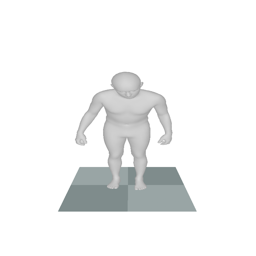

In [ ]:
smpl_params_w = {k:v.to(device) for k,v in batch['smpl_params_w'].items()}
verts = smplx(**smpl_params_w).vertices
verts = torch.stack([torch.matmul(smplx2smpl, v_) for v_ in verts])

offset = einsum(J_regressor, verts[0], "j v, v i -> j i")[0]  # (3)
offset[1] = verts[:, :, [1]].min()
verts = verts - offset
T_ay2ayfz = compute_T_ayfz2ay(einsum(J_regressor, verts[[0]], "j v, l v i -> l j i"), inverse=True)
verts = apply_T_on_points(verts, T_ay2ayfz)
joints = einsum(J_regressor, verts, "j v, l v i -> l j i")

i = 0
global_R, global_T, global_lights = get_global_cameras_static(
    verts.cpu(), beta=2.0, cam_height_degree=20, target_center_height=1.0, vec_rot=0,
)
_, _, K = create_camera_sensor(width, height, 24)
renderer_g = Renderer(width, height, device="cuda", faces=faces_smpl[0], K=K)

# -- render mesh -- #
scale, cx, cz = get_ground_params_from_points(joints[:, 0], verts)
renderer_g.set_ground(scale * 1.5, cx, cz)
color = torch.ones(3).float().cuda() * 0.8

cameras = renderer_g.create_camera(global_R[i], global_T[i])
img_gb = renderer_g.render_with_ground(verts[[i]], color[None], cameras, global_lights)
Image.fromarray(img_gb).resize((256,256))